In [1]:
import open3d as o3d
import numpy as np
import os
import sys 
import copy

sys.path.append('..')
import open3d_tutorial as o3dtut
o3dtut.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
def load_point_clouds(voxel_size=0.0):
    pcds = []
    for i in range(1,3):
        pcd = o3d.io.read_point_cloud("sync_%d.ply" %i)
        pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
        pcds.append(pcd_down)
    return pcds

After downsampling the point clouds, Visualize them together

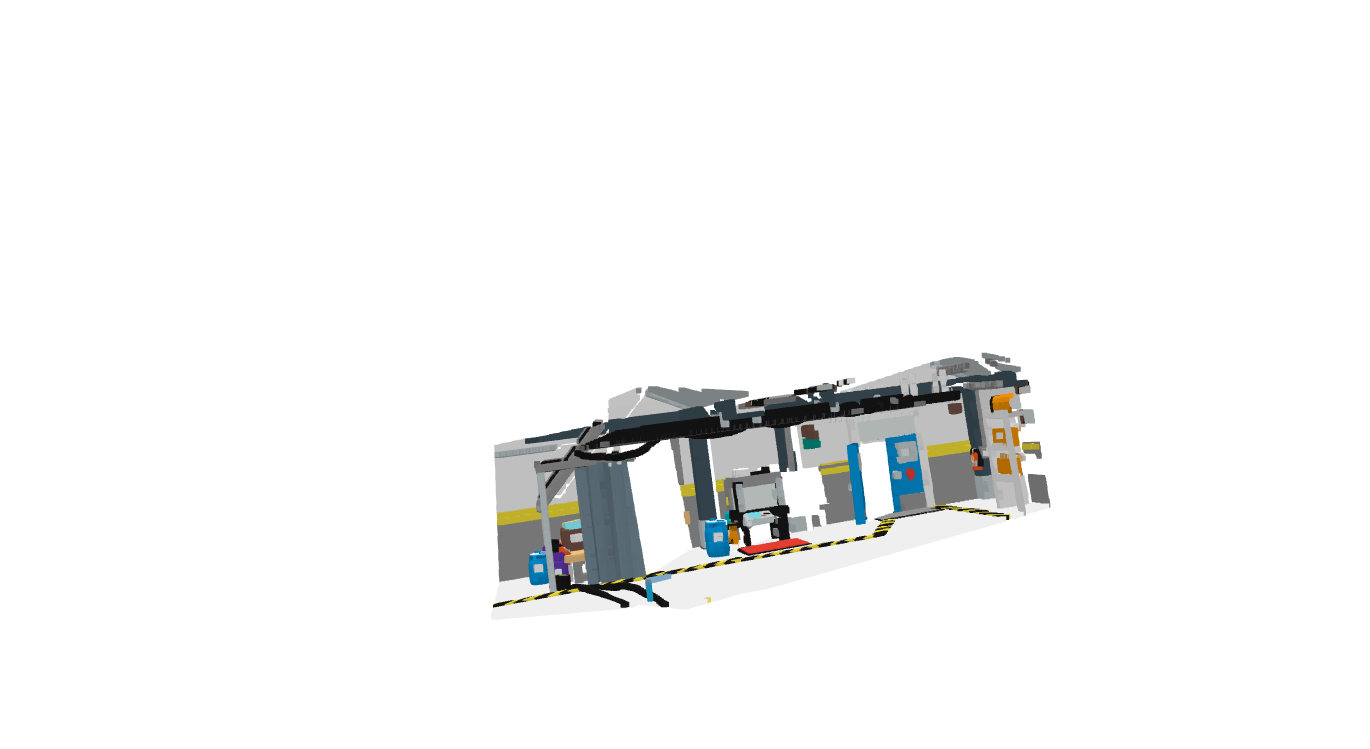

In [3]:
voxel_size = 0.02
pcds_down = load_point_clouds(voxel_size)
o3d.visualization.draw_geometries(pcds_down,
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

In [4]:
def pairwise_registration(source, target):
    print("Apply point-to-plane ICP")
    target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id])
            print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph

In [5]:
print("Full registration ...")
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5 
# max_correspondence_distance_fine = 0.03
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(pcds_down,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)

Full registration ...
Apply point-to-plane ICP
[Open3D DEBUG] ICP Iteration #0: Fitness 0.5684, RMSE 0.0887
[Open3D DEBUG] Residual : 1.81e-03 (# of elements : 35763)
[Open3D DEBUG] ICP Iteration #1: Fitness 0.5796, RMSE 0.0891
[Open3D DEBUG] Residual : 2.02e-03 (# of elements : 36463)
[Open3D DEBUG] ICP Iteration #2: Fitness 0.5827, RMSE 0.0894
[Open3D DEBUG] Residual : 2.11e-03 (# of elements : 36659)
[Open3D DEBUG] ICP Iteration #3: Fitness 0.5841, RMSE 0.0898
[Open3D DEBUG] Residual : 2.15e-03 (# of elements : 36749)
[Open3D DEBUG] ICP Iteration #4: Fitness 0.5850, RMSE 0.0900
[Open3D DEBUG] Residual : 2.19e-03 (# of elements : 36803)
[Open3D DEBUG] ICP Iteration #5: Fitness 0.5854, RMSE 0.0900
[Open3D DEBUG] Residual : 2.22e-03 (# of elements : 36831)
[Open3D DEBUG] ICP Iteration #6: Fitness 0.5857, RMSE 0.0901
[Open3D DEBUG] Residual : 2.24e-03 (# of elements : 36853)
[Open3D DEBUG] ICP Iteration #7: Fitness 0.5859, RMSE 0.0901
[Open3D DEBUG] Residual : 2.25e-03 (# of elements : 

In [6]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)

Optimizing PoseGraph ...
[Open3D DEBUG] Validating PoseGraph - finished.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 2 nodes and 1 edges.
[Open3D DEBUG] Line process weight : 24.546600
[Open3D DEBUG] [Initial     ] residual : 1.531310e-33, lambda : 5.605982e+00
[Open3D DEBUG] Maximum coefficient of right term < 1.000000e-06
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 2 nodes and 1 edges.
[Open3D DEBUG] Line process weight : 24.546600
[Open3D DEBUG] [Initial     ] residual : 1.531310e-33, lambda : 5.605982e+00
[Open3D DEBUG] Maximum coefficient of right term < 1.000000e-06
[Open3D DEBUG] CompensateReferencePoseGraphNode : reference : 0


Transform points and display
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 9.99999998e-01 -9.77605888e-06 -6.18200149e-05  9.90554767e-04]
 [ 9.76583568e-06  9.99999986e-01 -1.65368392e-04 -4.92679740e-04]
 [ 6.18216307e-05  1.65367788e-04  9.99999984e-01 -8.69211391e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


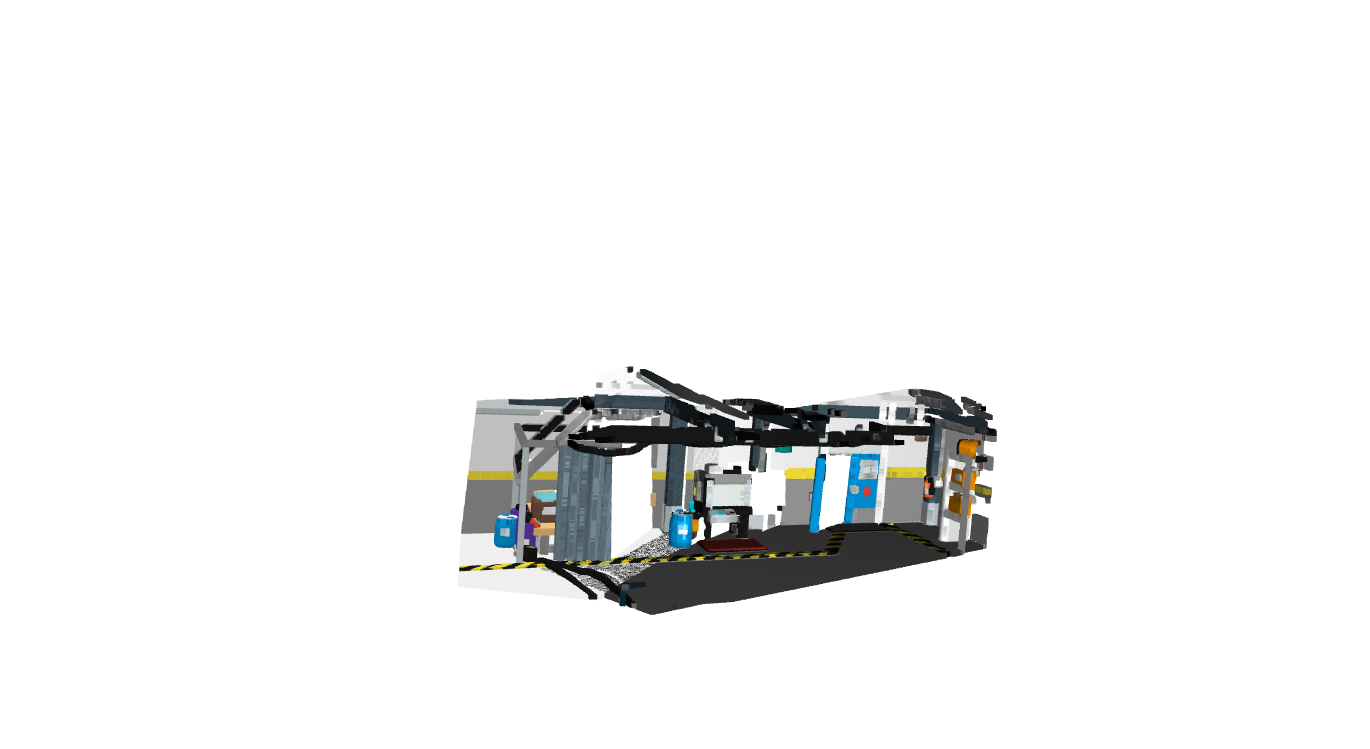

In [7]:
print("Transform points and display")
for point_id in range(len(pcds_down)):
    print(pose_graph.nodes[point_id].pose)
    pcds_down[point_id].transform(pose_graph.nodes[point_id].pose)
o3d.visualization.draw_geometries(pcds_down,
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

**Once the Two point clouds are registered, compute the distance between the points of the two point clouds :
1. Set the threshold = The maximum correspondence distance used during registration
2. Filter the points with distance less than the threshold (overlap/corresponding points)
3. Display point cloud consisting of only overlap points

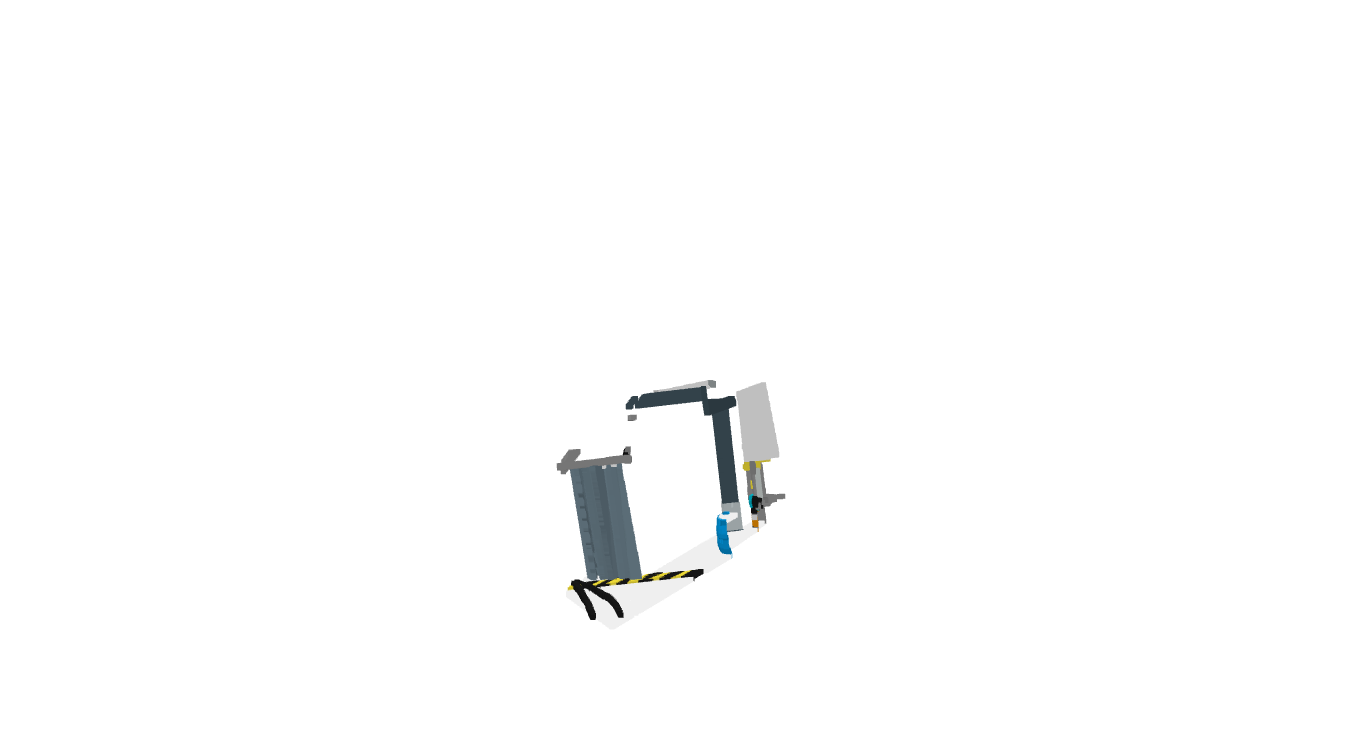

In [10]:
dists = pcds_down[0].compute_point_cloud_distance(pcds_down[1])
dists = np.asarray(dists)
ind = np.where(dists < 0.03)[0]
pcds_with_overlap = pcds_down[0].select_by_index(ind)
o3d.visualization.draw_geometries([pcds_with_overlap],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

**Downsample and combine the 2 registered point clouds into a single point cloud.

PointCloud with 202219 points.
PointCloud with 165127 points.


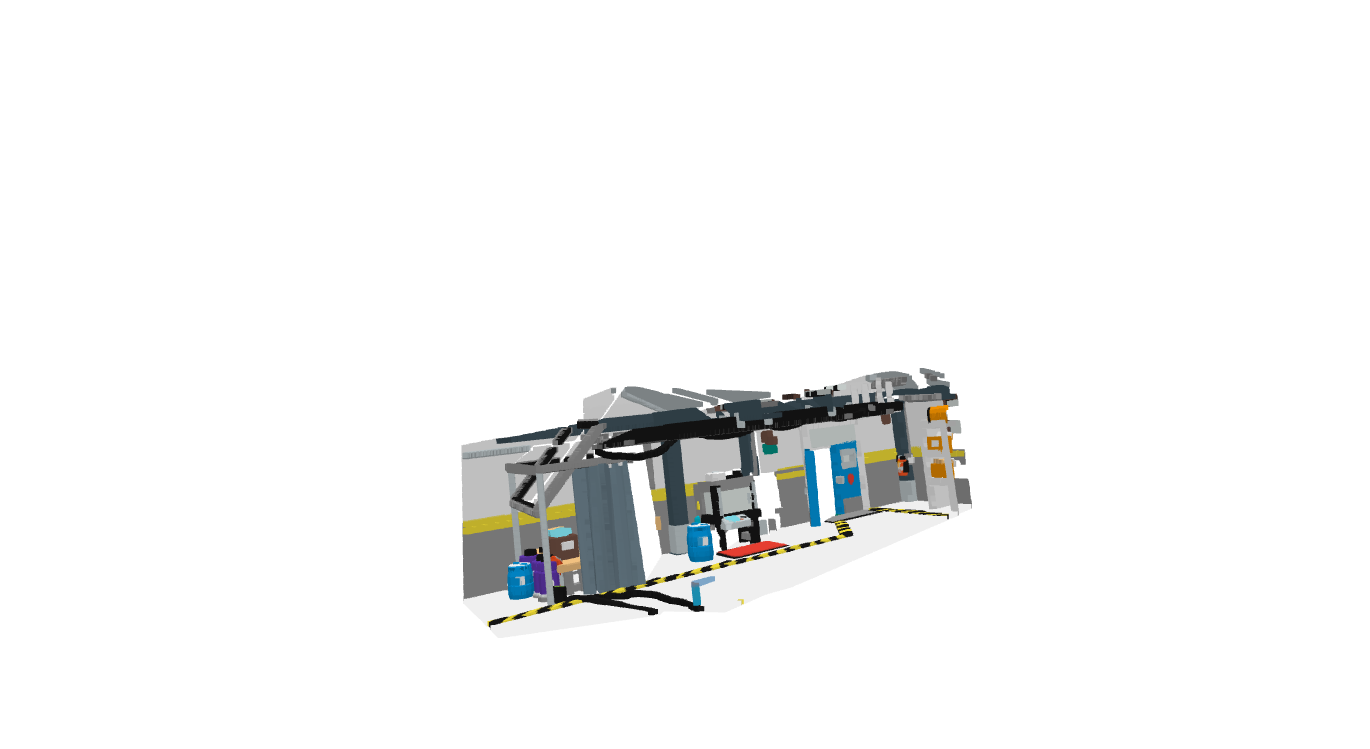

In [11]:
pcds = load_point_clouds(voxel_size)
pcd_combined = o3d.geometry.PointCloud()
for point_id in range(len(pcds)):
    pcds[point_id].transform(pose_graph.nodes[point_id].pose)
    pcd_combined += pcds[point_id]
print(pcd_combined)    
pcd_combined_down = pcd_combined.voxel_down_sample(voxel_size=voxel_size)
print(pcd_combined_down)
o3d.io.write_point_cloud("multiway_registration.pcd", pcd_combined_down)
o3d.visualization.draw_geometries([pcd_combined_down],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

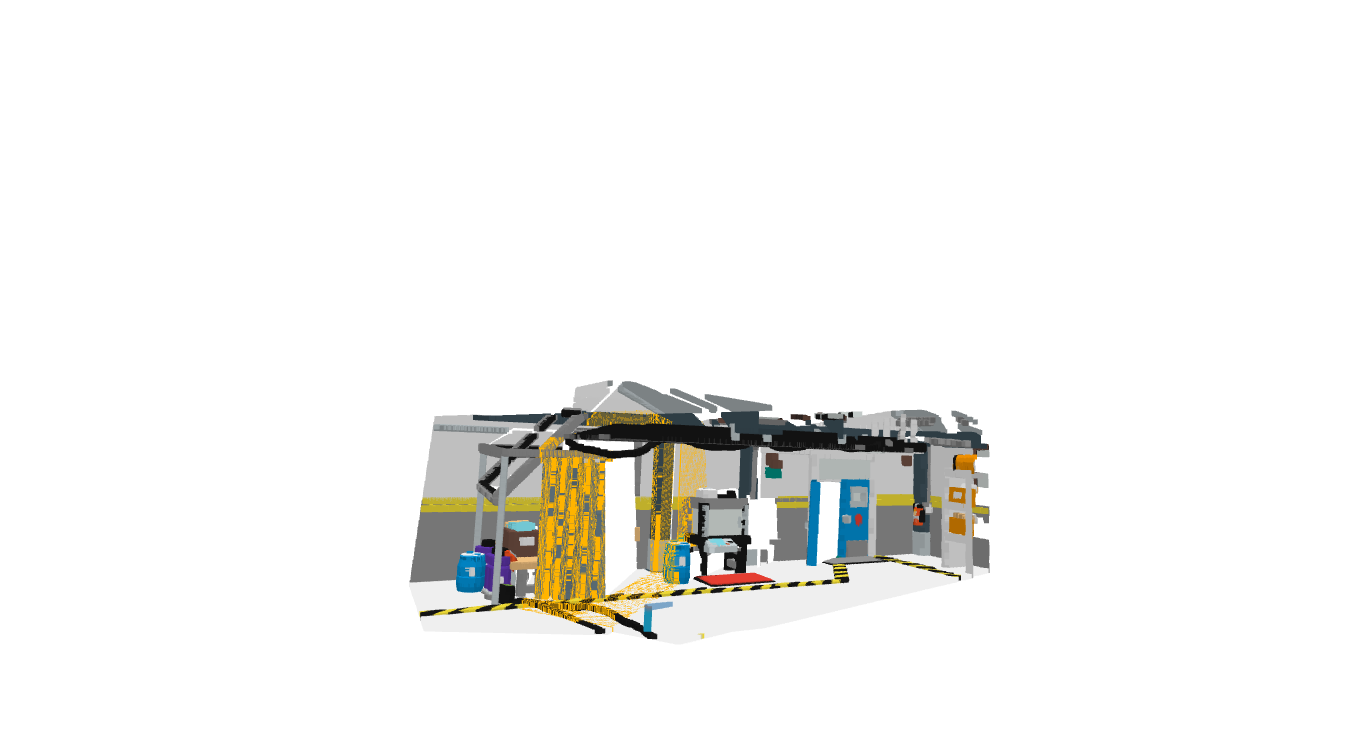

In [12]:
pcds_with_overlap.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([pcds_with_overlap,pcd_combined_down],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])